In [30]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2023-03-09 18:34:52
# @Last Modified: 2023-03-09 18:36:57
# ------------------------------------------------------------------------------ #
# Playground for building / testing the new api.
# Will be deleted before accepatance
# ------------------------------------------------------------------------------ #


%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-12s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import numpy as np
import xarray as xr
import pandas as pd

from tqdm import tqdm

sys.path.append('../')

from ana import utility as utl

%watermark -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

re            : 2.2.1
xarray        : 2023.7.0
matplotlib    : 3.7.2
sys           : 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:41) [Clang 15.0.7 ]
hdestimator   : 0.10b2
numpy         : 1.24.4
prompt_toolkit: 3.0.39
sqlite3       : 2.6.0
h5py          : 3.9.0
pandas        : 2.0.3
humanize      : 4.7.0
logging       : 0.5.1.2
IPython       : 8.14.0



In [31]:
# specify this as closely as possible, we search recursively through all subdirs
data_dir = "../../../gnode/experiment_analysis/dat/spikes/"
meta_df = utl.all_unit_metadata(data_dir, reload=True)
# meta_df = utl.load_spikes(meta_df)
meta_df = meta_df.iloc[:100]
meta_df


2023-08-04 13:24:27,722 | DEBUG    | ana.utility  | Found 58 hdf5 files in /Users/paul/para/2_Projects/information_timescales/repo/gnode/experiment_analysis/dat/spikes
Fetching metadata from sessions: 100%|██████████| 58/58 [00:00<00:00, 65.42it/s]


,unit_id,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,session,stimulus,block
unit_id,,,,,,,,,,
951013153,951013153,VISam,SUCCESS,900.668806,21.542880,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0
951013143,951013143,VISam,SUCCESS,900.718039,11.652925,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0
951013133,951013133,VISam,SUCCESS,894.867666,0.448111,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0
951013202,951013202,VISam,SUCCESS,900.265072,2.384853,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0
951013187,951013187,VISam,SUCCESS,896.074534,0.706414,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0
...,...,...,...,...,...,...,...,...,...,...
951023111,951023111,VISp,SUCCESS,900.523585,5.857703,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0
951023073,951023073,VISp,SUCCESS,899.032684,1.154574,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0
951023063,951023063,VISp,SUCCESS,900.525351,4.561782,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0


In [44]:
data_dir = "../../../gnode/experiment_analysis/dat/spikes/"
meta_df = utl.all_unit_metadata(data_dir, reload=True)
# meta_df = utl.load_spikes(meta_df)
meta_df = meta_df.iloc[:100]

bar = dict(foo="bar", lorem=1, ipsum=np.array([1,2,3]))
meta_df['bar'] = [bar]*100
meta_df.to_hdf('/Users/paul/Desktop/meta_df.h5', key='meta_df', mode='w')



loaded = pd.read_hdf('/Users/paul/Desktop/meta_df.h5', key='meta_df')
loaded

2023-08-02 17:41:11,918 | DEBUG    | ana.utility  | Found 58 hdf5 files in /Users/paul/para/2_Projects/information_timescales/repo/gnode/experiment_analysis/dat/spikes


,unit_id,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,session,stimulus,block,bar
unit_id,,,,,,,,,,,
951013153,951013153,VISam,SUCCESS,900.668806,21.542880,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0,"{'foo': 'bar', 'lorem': 1, 'ipsum': [1, 2, 3]}"
951013143,951013143,VISam,SUCCESS,900.718039,11.652925,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0,"{'foo': 'bar', 'lorem': 1, 'ipsum': [1, 2, 3]}"
951013133,951013133,VISam,SUCCESS,894.867666,0.448111,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0,"{'foo': 'bar', 'lorem': 1, 'ipsum': [1, 2, 3]}"
951013202,951013202,VISam,SUCCESS,900.265072,2.384853,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0,"{'foo': 'bar', 'lorem': 1, 'ipsum': [1, 2, 3]}"
951013187,951013187,VISam,SUCCESS,896.074534,0.706414,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0,"{'foo': 'bar', 'lorem': 1, 'ipsum': [1, 2, 3]}"
...,...,...,...,...,...,...,...,...,...,...,...
951023111,951023111,VISp,SUCCESS,900.523585,5.857703,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0,"{'foo': 'bar', 'lorem': 1, 'ipsum': [1, 2, 3]}"
951023073,951023073,VISp,SUCCESS,899.032684,1.154574,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0,"{'foo': 'bar', 'lorem': 1, 'ipsum': [1, 2, 3]}"
951023063,951023063,VISp,SUCCESS,900.525351,4.561782,/Users/paul/para/2_Projects/information_timesc...,30719,787025148,natural_movie_one_more_repeats,3.0,"{'foo': 'bar', 'lorem': 1, 'ipsum': [1, 2, 3]}"


In [45]:
loaded["bar"].iloc[0]["ipsum"]

array([1, 2, 3])

In [32]:
sd = utl.load_session("/Users/paul/para/2_Projects/information_timescales/repo/gnode/experiment_analysis/dat/spikes/session_715093703_spike_data.h5", as_dict=True)
sd[715093703]["natural_movie_three"]["3.0"]["data"].sel(unit_id = 950911932)

<xarray.DataArray (session: 1, stimulus: 1, block: 1, spiketimes: 48279)>
array([[[[2205.3657, 2205.7249, 2205.765 , ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
  * session   (session) int64 715093703
  * stimulus  (stimulus) object 'natural_movie_three'
  * block     (block) object '3.0'
    unit_id   int64 950911932
Dimensions without coordinates: spiketimes

In [34]:
import mrestimator as mre

print(mre.__version__)

sd = utl.load_session("/Users/paul/para/2_Projects/information_timescales/repo/gnode/experiment_analysis/dat/spikes/session_715093703_spike_data.h5", as_dict=True)
s_1 = sd[715093703]["natural_movie_three"]["3.0"]["data"].sel(unit_id = 950911932)
s_2 = sd[715093703]["natural_movie_three"]["3.0"]["data"].sel(unit_id = 950911986)
s_3 = sd[715093703]["natural_movie_three"]["3.0"]["data"].sel(unit_id = 950957053)

0.1.9b2


In [5]:
sd[715093703]["natural_movie_three"]["3.0"]["data"]

<xarray.DataArray (session: 1, stimulus: 1, block: 1, unit_id: 296,
                   spiketimes: 48279)>
array([[[[[2205.3657, 2205.7249, 2205.765 , ...,       nan,       nan,
                 nan],
          [2205.3242, 2206.765 , 2209.8555, ...,       nan,       nan,
                 nan],
          [2205.358 , 2205.4478, 2205.4648, ...,       nan,       nan,
                 nan],
          ...,
          [2205.5464, 2208.2717, 2208.338 , ...,       nan,       nan,
                 nan],
          [2205.3677, 2205.397 , 2205.4065, ...,       nan,       nan,
                 nan],
          [2213.2527, 2232.4814, 2232.5056, ...,       nan,       nan,
                 nan]]]]], dtype=float32)
Coordinates:
  * session   (session) int64 715093703
  * stimulus  (stimulus) object 'natural_movie_three'
  * block     (block) object '3.0'
  * unit_id   (unit_id) int64 950911932 950911986 ... 950956952 950957053
Dimensions without coordinates: spiketimes

2023-08-04 13:24:47,691 | DEBUG    | ana.utility  | Binning spiketimes: dtype <class 'numpy.ndarray'> with shape (1, 48279)
2023-08-04 13:24:47,899 | DEBUG    | ana.utility  | Binning spiketimes: dtype <class 'numpy.ndarray'> with shape (1, 48279)
2023-08-04 13:24:47,900 | DEBUG    | ana.utility  | Binning spiketimes: dtype <class 'numpy.ndarray'> with shape (1, 48279)
2023-08-04 13:24:48,051 | DEBUG    | ana.utility  | Binning spiketimes: dtype <class 'numpy.ndarray'> with shape (3, 48279)


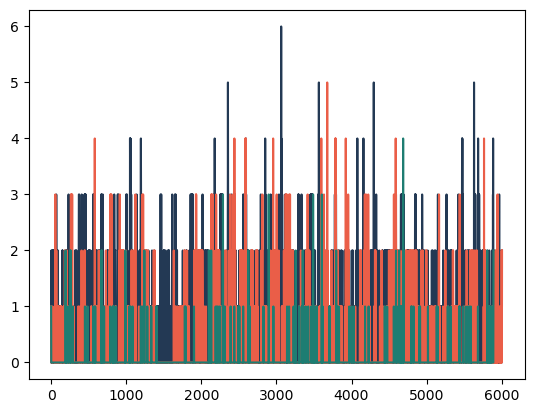

In [35]:
utl.log.setLevel('DEBUG')
b1 = utl.binned_spike_count(spiketimes=s_1.squeeze(), bin_size=0.1)
b2 = utl.binned_spike_count(spiketimes=s_2.squeeze(), bin_size=0.1)
b3 = utl.binned_spike_count(spiketimes=s_3.squeeze(), bin_size=0.1)

fig, ax = plt.subplots()

ax.plot(b1[0, :])
ax.plot(b2[0, :])
ax.plot(b3[0, :])

stack = np.vstack((s_1, s_2, s_3))
stack.squeeze()
b4 = utl.binned_spike_count(spiketimes=stack.squeeze(), bin_size=0.1)

import h5py as h5

# f = h5.File("/Users/paul/Desktop/data_ref.h5", "a")
# f.create_dataset("binned_spikes_1_100ms", data=b1[0, :], compression="gzip")
# f.create_dataset("binned_spikes_2_100ms", data=b2[0, :], compression="gzip")
# f.create_dataset("binned_spikes_3_100ms", data=b3[0, :], compression="gzip")
# f.create_dataset("binned_spikes_stacked_100ms", data=b3[0, :], compression="gzip")
# f.close()

In [7]:
np.all(b4[0,0:len(b2[0])] == b2[0])

False

In [39]:
rk = mre.coefficients(data=b3, dtunit='s', dt = 0.1)
fit = mre.fit(rk, fitfunc='two_ts')
# print(fit._asdict())
print(mre.popt_as_dict(fit.fitfunc, fit.popt))

{'tau1': 0.20218425434458412, 'A1': 0.3689900148738443, 'tau2': 9.99724738510919, 'A2': 0.010579779123241557}


In [43]:
fit._asdict()


<class 'dict'>
├── tau .............................................................. float64  0.20218425434458412
├── mre .............................................................. float64  0.6098157863883843
├── fitfunc ......................................................... function
├── taustderr ....................................................... NoneType
├── mrestderr ....................................................... NoneType
├── tauquantiles .................................................... NoneType
├── mrequantiles .................................................... NoneType
├── quantiles ....................................................... NoneType
├── popt ............................................................. ndarray  (4,)
├── pcov ............................................................. ndarray  (4, 4)
├── ssres ............................................................ float64  0.12850937676251126
├── rsquared ...........................

In [37]:
import inspect
mre.f_two_timescales
fit.popt
args = inspect.getfullargspec(mre.f_two_timescales)[0][1:]

dict(zip(args, fit.popt))

NameError: name 'fit' is not defined

In [36]:
fit.popt
mre.tau_from_popt(fit.fitfunc, fit.popt)

NameError: name 'fit' is not defined

In [23]:
data_dir = "../../../gnode/experiment_analysis/dat/spikes/"
meta_df = utl.all_unit_metadata(data_dir, reload=False)
# meta_df = utl.load_spikes(meta_df)
meta_df = meta_df.iloc[0:1]

# import hdestimator as hde

meta_df = utl.load_spikes(meta_df)
spikes = meta_df.iloc[0]["spiketimes"]
spikes = spikes.to_numpy().squeeze()
spikes = spikes[np.isfinite(spikes)]

import hdestimator as hde
hde.api.log.setLevel("DEBUG")

import mrestimator as mre


embedding_past_range_set = [0.005, 0.00561, 0.00629, 0.00706, 0.00792,
0.00889, 0.00998, 0.01119, 0.01256, 0.01409, 0.01581, 0.01774,
0.01991, 0.02233, 0.02506, 0.02812, 0.03155, 0.0354, 0.03972, 0.04456,
0.05, 0.0561, 0.06295,
0.06441, 0.06591, 0.06745, 0.06902, 0.07063, 0.07227, 0.07396, 0.07568,
0.07744, 0.07924, 0.08109, 0.08298, 0.08491, 0.08689, 0.08891, 0.09099,
0.0931, 0.09527, 0.09749, 0.09976, 0.10209, 0.10446, 0.1069, 0.10939,
0.11194, 0.11454, 0.11721, 0.11994, 0.12274, 0.12559, 0.12852, 0.13151,
0.13458, 0.13771, 0.14092, 0.1442, 0.14756, 0.151, 0.15451, 0.15811,
0.1618, 0.16557, 0.16942, 0.17337, 0.17741, 0.18154, 0.18577, 0.19009,
0.19452, 0.19905, 0.20369, 0.20843, 0.21329, 0.21826, 0.22334,
0.25059, 0.28117, 0.31548, 0.35397, 0.39716, 0.44563, 0.5, 0.56101, 0.62946,
0.70627, 0.79245, 0.88914, 0.99763, 1.11936, 1.25594, 1.40919,
1.58114, 1.77407, 1.99054, 2.23342, 2.50594, 2.81171, 3.15479,
3.53973, 3.97164, 4.45625, 5.0]

res = hde.api.wrapper(
    spike_times=spikes,
    settings = {
        "number_of_bootstraps_R_tot": 0,
        "number_of_bootstraps_R_max": 250,
        "timescale_minimum_past_range": 30/1000,
        "embedding_number_of_bins_set": [5],
        "estimation_method": "shuffling",
        "embedding_past_range_set": embedding_past_range_set,
    }
)




2023-08-04 11:46:53,991 | DEBUG    | ana.utility  | Using cached metadata
2023-08-04 11:46:54,020 | DEBUG    | ana.utility  | Loading spikes for 1 units, 1 rows for pandas dataframe.
Loading spikes for sessions: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]
2023-08-04 11:46:54,135 | DEBUG    | hdestimator  | Python wrapper with settings: {'embedding_step_size': 0.005, 'embedding_past_range_set': [0.005, 0.00561, 0.00629, 0.00706, 0.00792, 0.00889, 0.00998, 0.01119, 0.01256, 0.01409, 0.01581, 0.01774, 0.01991, 0.02233, 0.02506, 0.02812, 0.03155, 0.0354, 0.03972, 0.04456, 0.05, 0.0561, 0.06295, 0.06441, 0.06591, 0.06745, 0.06902, 0.07063, 0.07227, 0.07396, 0.07568, 0.07744, 0.07924, 0.08109, 0.08298, 0.08491, 0.08689, 0.08891, 0.09099, 0.0931, 0.09527, 0.09749, 0.09976, 0.10209, 0.10446, 0.1069, 0.10939, 0.11194, 0.11454, 0.11721, 0.11994, 0.12274, 0.12559, 0.12852, 0.13151, 0.13458, 0.13771, 0.14092, 0.1442, 0.14756, 0.151, 0.15451, 0.15811, 0.1618, 0.16557, 0.16942, 0.17337, 0.17741, 0

In [24]:
res

<class 'dict'>
├── firing_rate ...................................................... float64  21.52952801803102
├── firing_rate_sd ................................................... float64  0.0
├── recording_length ................................................. float64  900.668701171875
├── recording_length_sd .............................................. float64  0.0
├── H_spiking ........................................................ float64  0.34156872139915495
├── R_tot ............................................................ float64  0.03332835049792322
├── R_tot_sd ........................................................ NoneType
├── AIS_tot .......................................................... float64  0.011383922065918525
├── T_D ................................................................ float  0.06441
├── tau_R ............................................................ float64  0.011799304491435247
├── opt_first_bin_size ..............................

In [29]:
import humanize

humanize.naturalsize(spikes.nbytes)

'77.6 kB'